## This notebook is used to parse the Index_history.txt files associated with the following two CMEMS datasets:

### CMEMS_hist048:  INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048
https://data.marine.copernicus.eu/product/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/description
ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr

### CMEMS_hist030:  INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030 (History)
https://data.marine.copernicus.eu/product/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/description
ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/cmems_obs-ins_glo_phybgcwav_mynrt_na_irr

### CMEMS_ref030:  INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030 (Reference)
https://data.marine.copernicus.eu/product/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/description
ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030/cmems_obs-ins_glo_phybgcwav_mynrt_na_irr

In [89]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from shapely.geometry import Point, Polygon
import xarray as xr
from IPython.display import display
%matplotlib inline

drifter_dir = "C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/"

cmems_hist048_dir = "INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048"
cmems_hist030_dir = "INSITU_GLO_PHYBGCWAV_DISCRETE_MYNRT_013_030"

cmems_dataset1_datafile = os.path.join(drifter_dir, cmems_hist048_dir, "GL_TS_DC_1300636.nc")
cmems_dataset2_datafile = os.path.join(drifter_dir, cmems_hist030_dir, "GL_PR_BO_EXO10556.nc")

updated_hist030_dir = os.path.join(drifter_dir, "updated_20231025", "hist030")
updated_hist048_dir = os.path.join(drifter_dir, "updated_20231025", "hist048")

## First, parse the index_history.txt file to find the tracks that are in the correct date and geospatial range (i.e., 1993 to 2020 and on the NL/LAB Shelves) 

In [141]:
LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox',
                                          ('minlon', 'maxlon', 'minlat', 'maxlat'))

shelf_coords = LatLonBoundingBox(minlon=-90, maxlon=-30, minlat=35, maxlat=80)
#shelf_coords = LatLonBoundingBox(minlon=-64.76, maxlon=-43.83, minlat=43.42, maxlat=60.88)
shelf_polygon = Polygon([(shelf_coords.maxlon, shelf_coords.maxlat),
                         (shelf_coords.maxlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.minlat),
                         (shelf_coords.minlon, shelf_coords.maxlat)])


def read_index_csv(index_file):
    # cmems index headers:
    # product_id,file_name,geospatial_lat_min,geospatial_lat_max,geospatial_lon_min,geospatial_lon_max,
    # time_coverage_start,time_coverage_end,institution,date_update,data_mode,parameters
    history_index = pd.read_csv(index_file)
    return history_index


def display_all_pd_rows(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 10):
        display(df) #need display to show the dataframe when using with in jupyter


def point_in_polygon(pt, poly):
    point = Point(pt)
    bool_within = point.within(poly) 
    #bool_contains = poly.contains(point)
    return(bool_within)


def regions_overlap(region1, region2):
    return(region1.intersects(region2))


def create_track_polygon(track):
    track_coords = LatLonBoundingBox(minlon=track['geospatial_lon_min'],
                                     maxlon=track['geospatial_lon_max'],
                                     minlat=track['geospatial_lat_min'],
                                     maxlat=track['geospatial_lat_max'])
    track_polygon = Polygon([(track_coords.maxlon, track_coords.maxlat),
                             (track_coords.maxlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.maxlat)])
    return track_polygon, track_coords


def find_plot_coords(shelf_coords, track_coords):
    """ get the mins and maxs to use with the plot such that both the track and shelf coords are included
    add a buffer so that the regions are not stuck on the plot boundaries """
    return LatLonBoundingBox(minlon=min(float(track_coords.minlon), float(shelf_coords.minlon)) - 2,
                             maxlon=max(float(track_coords.maxlon), float(shelf_coords.maxlon)) + 2,
                             minlat=min(float(track_coords.minlat), float(shelf_coords.minlat)) - 2,
                             maxlat=max(float(track_coords.maxlat), float(shelf_coords.maxlat)) + 2)
    
    
def plot_regions(pgon1, pgon2, plot_coords):
    # plot the two polygon regions
    #bounds = [plot_coords.minlon - 2, plot_coords.maxlon + 2, plot_coords.minlat - 2, plot_coords.maxlat + 2]
    bounds = [plot_coords.minlon, plot_coords.maxlon, plot_coords.minlat, plot_coords.maxlat]
    plt.figure(figsize=(5, 3))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)
    ax.add_geometries([pgon1], crs=ccrs.PlateCarree(), facecolor='b', edgecolor='red', alpha=0.5)
    ax.add_geometries([pgon2], crs=ccrs.PlateCarree(), facecolor='g', edgecolor='red', alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    #gl.xlines = False
    plt.show()

    
def wrap_to_180(x):
    """Wrap values in degrees into the interval [-180, 180]."""
    if isinstance(x, np.ndarray):
        with np.errstate(invalid='ignore'):
            x_wrap = np.remainder(x, 360)
        x_wrap[x_wrap > 180] -= 360
        return x_wrap
    elif hasattr(x, "__len__"):
        return wrap_to_180(np.array(x))
    else:
        return wrap_to_180(np.array([x]))[0]    
    

def select_relevant_data_from_index(folder, txt_fname="index_history.txt", search_subfolder=False): 
    """ read in the index file and add a few columns for convienience """
    index_file = os.path.join(drifter_dir, folder, txt_fname)
    history_index = read_index_csv(index_file)
        
    # First, exclude files with start dates later than 2020 or end dates earlier than 1993
    history_index['time_coverage_start'] = pd.to_datetime(history_index.time_coverage_start.values)
    history_index['time_coverage_end'] = pd.to_datetime(history_index.time_coverage_end.values)
    hist_index_earliest_time = str(np.nanmin(history_index['time_coverage_start'])).split(' ')[0]
    hist_index_latest_time = str(np.nanmax(history_index['time_coverage_end'])).split(' ')[0]
    hindexdf = history_index.loc[(history_index.time_coverage_start.dt.year.isin(range(1993, 2021))) 
                                  & (history_index.time_coverage_end.dt.year >= 1993)]
    
    # Next, only keep files where the geospatial coordinates overlap the NL and LAB shelves 
    # This is only approximate (needs actual coords)
    keepfiles = []
    keep_rows = []

    for t_ind, t in hindexdf.iterrows():
        
        if search_subfolder:
            subdir = os.path.dirname(t.file_name).split('/')[-1]
            if subdir != 'DB':
                continue
        
        track_polygon, track_coords = create_track_polygon(t) 
        plot_coords = find_plot_coords(shelf_coords, track_coords)
        keep_row = False    
        if regions_overlap(track_polygon, shelf_polygon):
            #print(os.path.basename(t.file_name))
            #if os.path.basename(t.file_name) == "GL_TS_DB_1300527.nc":
            #    print('\n\n', os.path.basename(t.file_name), '\n', shelf_polygon, '\n', track_polygon, '\n\n')
            #if os.path.basename(t.file_name) == "GL_TS_DC_1300527.nc":
            #    print('\n\n', os.path.basename(t.file_name), '\n', shelf_polygon, '\n', track_polygon, '\n\n')
            keep_row = True
        
        # This is likely slower, but I'm including it while trying to debug the fact that the 
        # the header of one of my representative drifters says it's in the shelf_coords but the 
        # lats and lons inside the file says otherwise.
        xx, yy = track_polygon.exterior.coords.xy
        plot_edge_points = list(zip(xx, yy))
        for pt in plot_edge_points:
            if point_in_polygon(pt, shelf_polygon):
                keep_row = True
            
        if keep_row:
            keepfiles.append(t['file_name'])
            keep_rows.append(t)
            
    # create a new dataframe that only contains the relevant data
    keep_index = pd.DataFrame(keep_rows)
    keep_index.reset_index(inplace=True)
    
    keep_index_earliest_time = str(np.nanmin(keep_index['time_coverage_start'])).split(' ')[0]
    keep_index_latest_time = str(np.nanmax(keep_index['time_coverage_end'])).split(' ')[0]

    # display a quick summary
    print('\nSummary')
    print('---------\n')
    print(
        'The following results only consider the index file, so some points in each track may still be outside the test area'
        + '\n\nThere were ' + str(len(history_index)) + ' tracks originally covering times from ' 
        + hist_index_earliest_time + ' to ' + hist_index_latest_time + '.\n' 
        + str(len(hindexdf)) + ' tracks have start and/or end dates inside the date range.\n' 
        + str(len(keepfiles)) + ' tracks are in both the right timeframe and cross the NL and LAB shelves.\n'
        + 'The time range in the reduced dataset is ' +  keep_index_earliest_time + ' to ' + keep_index_latest_time
        # + 'The files can be downloaded from the CMEMS ftp using the paths in the keepfiles list'
    )
    
    # only return the files that are in the right time and geospatial ranges 
    return keep_index

    
def explore_cmems_datafile(fname):
    with xr.load_dataset(fname) as cds:
        print(cds.info)
        

def create_track_polygon_from_netcdf(ds):
    # used when plotting a representative figure
    attrs = ds.attrs
    track_coords = LatLonBoundingBox(minlon=float(attrs['geospatial_lon_min']),
                                     maxlon=float(attrs['geospatial_lon_max']),
                                     minlat=float(attrs['geospatial_lat_min']),
                                     maxlat=float(attrs['geospatial_lat_max']))
    track_polygon = Polygon([(track_coords.maxlon, track_coords.maxlat),
                             (track_coords.maxlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.minlat),
                             (track_coords.minlon, track_coords.maxlat)])
    return track_polygon, track_coords

        
def create_representative_plot(cds):
    track_polygon, track_coords = create_track_polygon_from_netcdf(cds)
    plot_coords = find_plot_coords(shelf_coords, track_coords)
    plot_regions(track_polygon, shelf_polygon, plot_coords)
    
    
def print_formatted_dataset_info(ds):
    print(ds.coords, '\n')
    print(ds.data_vars)
    print('\nDimensions')
    for dim, val in ds.dims.items():
        print('  ' + str(dim) + ': ' + str(val))
    print('\nAttributes:')
    for attr, val in ds.attrs.items():
        print('  ' + str(attr) + ': ' + str(val))
        
        
def explore_the_dataset(dataset_to_explore, 
                        datafile,
                        txt_fname="index_history.txt",
                        show_2019=False, 
                        show_indv_file=False, 
                        show_representative_plot=False,
                        save_ftp_links=False,
                        search_subfolder=False):
    
    print("dataset: " + dataset_to_explore + '\n\ndatafile: ' + datafile + '\n')
    keep_index = select_relevant_data_from_index(dataset_to_explore, txt_fname, search_subfolder=search_subfolder)
    
    if show_2019:
        print('\nDrifters active in 2019')
        print('-------------------------\n')
        # check 2019 as an example:
        active_in_2019 = keep_index.loc[(keep_index['start_year']<=2019) & (keep_index['end_year']>=2019)]
        print(len(active_in_2019), 'drifters active in 2019\n')
        
    if show_indv_file or show_representative_plot:
        with xr.load_dataset(datafile) as cds:
            if show_representative_plot:
                print('\nRepresentative plot of ' + str(os.path.basename(datafile)))
                print('-----------------------------------------')
                create_representative_plot(cds)
            if show_indv_file:
                print('Showing info for a representative file: ')
                print('\nThe information from index_history.txt:')
                print('-----------------------------------------\n')
                print(keep_index.iloc[0], '\n\n')
                print('\nThe information from inside the actual datafile:')
                print('--------------------------------------------------\n')
                print_formatted_dataset_info(cds)      
    
    if save_ftp_links:            
        ftps = keep_index['file_name'].values.tolist()
        ftplinks = [(ftp + '\n') for ftp in ftps]
        dataset_type = txt_fname.replace("index_", "").replace(".txt", "")
        savename = dataset_to_explore + '_' + dataset_type + '_ftp-file-list.txt'
        savepath = os.path.join(drifter_dir, savename)
        print('\nSaving list of files to download: ' + savepath)
        with open(savepath, "w") as file1:
            file1.writelines(ftplinks)

## CMEMS hist030 (updated 20231025)

dataset: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/updated_20231025\hist030

datafile: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/updated_20231025\hist030\GL_TS_DB_1300529.nc


Summary
---------

The following results only consider the index file, so some points in each track may still be outside the test area

There were 67647 tracks originally covering times from 1821-05-25 to 2023-10-24.
49520 tracks have start and/or end dates inside the date range.
3389 tracks are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 1993-01-15 to 2023-09-30

Representative plot of GL_TS_DB_1300529.nc


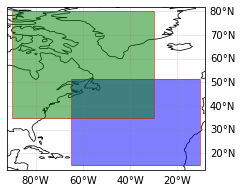

Showing info for: GL_TS_DB_1300529.nc
Coordinates:
  * TIME       (TIME) datetime64[ns] 2005-02-23T18:10:00 ... 2019-06-11T16:30:00
  * LATITUDE   (LATITUDE) float32 29.17 29.19 29.19 29.19 ... 50.85 50.68 50.21
  * LONGITUDE  (LONGITUDE) float32 -15.69 -15.69 -15.7 ... -10.48 -10.38 -10.11 

Data variables:
    TIME_QC       (TIME) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    POSITION_QC   (POSITION) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 4.0 1.0 1.0 4.0
    DC_REFERENCE  (TIME) object b'101305024                       ' ... b'163...
    DEPH          (TIME, DEPTH) float32 0.0 nan 0.0 nan 0.0 ... 0.0 nan 0.0 nan
    DEPH_QC       (TIME, DEPTH) float32 7.0 nan 7.0 nan 7.0 ... 7.0 nan 7.0 nan
    TEMP          (TIME, DEPTH) float64 17.9 nan 18.0 nan ... 38.3 nan 27.98 nan
    TEMP_QC       (TIME, DEPTH) float32 1.0 nan 1.0 nan 1.0 ... 2.0 nan 2.0 nan
    PSAL          (TIME, DEPTH) float64 nan nan nan nan nan ... nan nan nan nan
    PSAL_QC       (TIME, DEPTH) float32 nan na

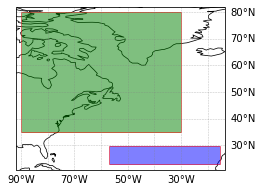

Showing info for: GL_TS_DB_1300529A.nc
Coordinates:
  * TIME       (TIME) datetime64[ns] 2005-02-15T15:36:32 ... 2007-05-26T07:18...
  * LATITUDE   (LATITUDE) float32 29.18 29.18 29.18 29.18 ... 27.37 27.36 27.36
  * LONGITUDE  (LONGITUDE) float32 -15.37 -15.37 -15.37 ... -57.03 -57.03 -57.03 

Data variables:
    TIME_QC       (TIME) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    POSITION_QC   (POSITION) float32 8.0 8.0 8.0 8.0 8.0 ... 8.0 8.0 8.0 8.0 8.0
    DC_REFERENCE  (TIME) object b'2094255578                      ' ... b'209...
    DEPH          (TIME, DEPTH) float32 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    DEPH_QC       (TIME, DEPTH) float32 7.0 7.0 7.0 7.0 7.0 ... 7.0 7.0 7.0 7.0
    TEMP          (TIME, DEPTH) float64 18.4 18.4 18.35 ... 24.38 24.38 24.38
    TEMP_QC       (TIME, DEPTH) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

Dimensions
  TIME: 19125
  LATITUDE: 19125
  LONGITUDE: 19125
  POSITION: 19125
  DEPTH: 1

Attributes:
  platform_code: 13005

In [142]:
keep_index = explore_the_dataset(updated_hist030_dir, 
                                 os.path.join(updated_hist030_dir, "GL_TS_DB_1300529.nc"), 
                                 show_indv_file=False, #True, 
                                 show_representative_plot=False, #True,
                                 save_ftp_links=False, #True,
                                 search_subfolder=True)

def look_at_indv_file(datafile):
    with xr.load_dataset(datafile) as cds:
        print('\nRepresentative plot of ' + str(os.path.basename(datafile)))
        create_representative_plot(cds)
        print('Showing info for: ' + str(os.path.basename(datafile)))
        print_formatted_dataset_info(cds) 
        
look_at_indv_file(os.path.join(updated_hist030_dir, "GL_TS_DB_1300529.nc"))
look_at_indv_file(os.path.join(updated_hist030_dir, "GL_TS_DB_1300529A.nc"))

## CMEMS hist048 (updated 20231025)

dataset: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/updated_20231025\hist048

datafile: C:/Users/HoldenJe/Drift/projects/gridded_velocity_products/drifter_data/CMEMS/updated_20231025\hist048\GL_TS_DC_1300529.nc


Summary
---------

The following results only consider the index file, so some points in each track may still be outside the test area

There were 14956 tracks originally covering times from 1986-06-02 to 2023-09-30.
13075 tracks have start and/or end dates inside the date range.
2106 tracks are in both the right timeframe and cross the NL and LAB shelves.
The time range in the reduced dataset is 2002-01-01 to 2023-09-30

Representative plot of GL_TS_DC_1300529.nc
-----------------------------------------


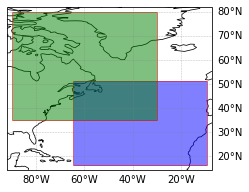

Showing info for a representative file: 

The information from index_history.txt:
-----------------------------------------

index                                                                129
product_id                                                 COP-GLOBAL-01
file_name              ftp://nrt.cmems-du.eu/Core/INSITU_GLO_PHY_UV_D...
geospatial_lat_min                                                23.568
geospatial_lat_max                                                37.565
geospatial_lon_min                                               -67.323
geospatial_lon_max                                               -22.261
time_coverage_start                            2013-10-20 00:00:00+00:00
time_coverage_end                              2016-08-21 12:00:00+00:00
institution            Atlantic Oceanographic and Meteorological Labo...
date_update                                         2019-03-06T11:03:33Z
data_mode                                                              R

In [143]:
keep_index = explore_the_dataset(updated_hist048_dir, 
                                 os.path.join(updated_hist048_dir, "GL_TS_DC_1300529.nc"),  
                                 show_indv_file=True, 
                                 show_representative_plot=True,
                                 save_ftp_links=False)